In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/My Drive/Colab Notebooks/ee247/project

/content/gdrive/My Drive/Colab Notebooks/ee247/project


In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 22kB/s 
     |████████████████████████████████| 3.9MB 49.6MB/s 
     |████████████████████████████████| 450kB 69.6MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras 

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

X_test = np.expand_dims(X_test, axis=3)
X_train_valid = np.expand_dims(X_train_valid, axis=3)
y_train_valid = y_train_valid - 769
y_test = y_test - 769
y_train_valid = keras.utils.to_categorical(y_train_valid)
y_test = keras.utils.to_categorical(y_test)

In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000, 1)
Test data shape: (443, 22, 1000, 1)
Training/Valid target shape: (2115, 4)
Test target shape: (443, 4)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [ ]:
def cnn_model(time_bin):
    model = keras.models.Sequential()

    #   tf.keras.layers.Conv2D(
    #     filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    #     dilation_rate=(1, 1), activation=None, use_bias=True,
    #     kernel_initializer='glorot_uniform', bias_initializer='zeros',
    #     kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    #     kernel_constraint=None, bias_constraint=None, **kwargs
    # )

    model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), kernel_regularizer=keras.regularizers.L1L2(0,0.35), input_shape=(22, time_bin, 1)))
    model.add(keras.layers.ELU())
    model.add(keras.layers.BatchNormalization(axis=1))
    model.add(keras.layers.MaxPool2D((1, 2)))

    model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), kernel_regularizer=keras.regularizers.L1L2(0,0.35)))
    model.add(keras.layers.ELU())
    model.add(keras.layers.BatchNormalization(axis=1))
    model.add(keras.layers.MaxPool2D((1,2)))

    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), kernel_regularizer=keras.regularizers.L1L2(0,0.35)))
    model.add(keras.layers.ELU())
    model.add(keras.layers.BatchNormalization(axis=1))
    model.add(keras.layers.MaxPool2D((1, 2)))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Conv2D(16, kernel_size=(3, 3), kernel_regularizer=keras.regularizers.L1L2(0,0.35)))
    model.add(keras.layers.ELU())
    model.add(keras.layers.BatchNormalization(axis=1))
    model.add(keras.layers.MaxPool2D((1, 2)))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(4, kernel_regularizer=keras.regularizers.L1L2(0,0.35), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer= keras.optimizers.Adam(lr=0.001, epsilon=1e-8, decay=0.01), metrics=[keras.metrics.categorical_accuracy])
    return model

In [ ]:
def train_data_time(time_bin):
    # different period of time
    x_train_in = X_train_valid[:, :, :time_bin,:]
    y_train_in = y_train_valid
    x_test_in = X_test[:, :, :time_bin,:]
    y_test_in = y_test

    lecun = keras.initializers.lecun_uniform()
    model = cnn_model(time_bin)

    # fit( x, y, batch_size=32, epochs=10, verbose=1, callbacks=None,
    # validation_split=0.0, validation_data=None, shuffle=True, 
    # class_weight=None, sample_weight=None, initial_epoch=0)

    model.fit(x_train_in, y_train_in, epochs=20, verbose=0, batch_size=25, validation_data=(x_test_in, y_test_in))
    train = model.evaluate(x_train_in, y_train_in)
    test = model.evaluate(x_test_in, y_test_in)

    return train[1]*100, test[1]*100

time = 200 start
443/443 [==============================] - 0s 525us/sample - loss: 1.2223 - categorical_accuracy: 0.5643
time = 300 start
443/443 [==============================] - 0s 783us/sample - loss: 1.1453 - categorical_accuracy: 0.6479
time = 400 start
443/443 [==============================] - 0s 904us/sample - loss: 1.1207 - categorical_accuracy: 0.6727
time = 500 start
443/443 [==============================] - 0s 1ms/sample - loss: 1.1585 - categorical_accuracy: 0.6591
time = 600 start
443/443 [==============================] - 0s 1ms/sample - loss: 1.1719 - categorical_accuracy: 0.6456
time = 700 start
443/443 [==============================] - 1s 1ms/sample - loss: 1.2154 - categorical_accuracy: 0.6343
time = 800 start
443/443 [==============================] - 1s 1ms/sample - loss: 1.2169 - categorical_accuracy: 0.6230
time = 900 start
443/443 [==============================] - 1s 1ms/sample - loss: 1.3098 - categorical_accuracy: 0.6095
time = 1000 start
443/443 [=======

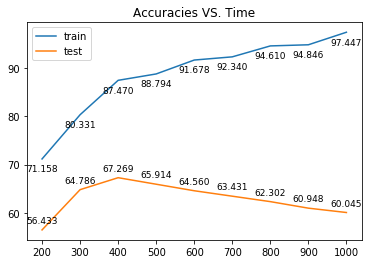

In [ ]:
train_time = []
test_time = []

for time in range(200, 1001, 100):
  print("time = %d start" %(time))
  temp1, temp2 = train_data_time(time)
  train_time.append(temp1)
  test_time.append(temp2)

plt.plot(range(200, 1001, 100), train_time, label='train')
plt.plot(range(200, 1001, 100), test_time, label='test')
plt.legend()
plt.title("Accuracies VS. Time")
for a,b,c in zip(range(200, 1001, 100),train_time,test_time):
  plt.text(a, b-3, '%.3f' % b, ha='center', va= 'bottom',fontsize=9)
  plt.text(a, c+1, '%.3f' % c, ha='center', va= 'bottom',fontsize=9)
plt.show()


In [ ]:
def train_data_subject(subject_num):

    # from pervious section, we found time_bin = 400 has better performance
    time_bin = 400
    x_train_in = X_train_valid[:, :, :time_bin,:]
    y_train_in = y_train_valid
    x_test_in = X_test[:, :, :time_bin,:]
    y_test_in = y_test

    if subject_num < 9:
      itemindex_train = np.argwhere(person_train_valid == subject_num)
      itemindex_train = np.delete(itemindex_train, -1, axis=1).reshape(-1,)
      x_train_in = x_train_in[itemindex_train, :, :,:]
      y_train_in = y_train_valid[itemindex_train,:]

    lecun = keras.initializers.lecun_uniform()
    model = cnn_model(time_bin)

    model.fit(x_train_in, y_train_in, epochs=20, verbose=0, batch_size=25, validation_data=(x_test_in, y_test_in))
    train = model.evaluate(x_train_in, y_train_in)
    test = model.evaluate(x_test_in, y_test_in)

    return train[1]*100, test[1]*100

In [ ]:
for subject_num in range(0,9):
  print("subject_num = %d start" %(subject_num))
  train_acc, test_acc = train_data_subject(subject_num)
  print("train_subject {:d} has trian acc = {:.3f}% and test acc = {:.3f}%" .format(subject_num, train_acc,test_acc))

print("subject_num = ALL start")
train_acc, test_acc = train_data_subject(9)
print("train_subject ALL has trian acc = {:.3f}% and test acc = {:.3f}%" .format(train_acc,test_acc))

subject_num = 0 start
443/443 [==============================] - 0s 526us/sample - loss: 3.6719 - categorical_accuracy: 0.3251
train_subject 0 has trian acc = 83.966% and test acc = 32.506%
subject_num = 1 start
443/443 [==============================] - 0s 511us/sample - loss: 3.9091 - categorical_accuracy: 0.2777
train_subject 1 has trian acc = 58.475% and test acc = 27.765%
subject_num = 2 start
443/443 [==============================] - 0s 526us/sample - loss: 3.8258 - categorical_accuracy: 0.2822
train_subject 2 has trian acc = 49.576% and test acc = 28.217%
subject_num = 3 start
443/443 [==============================] - 0s 505us/sample - loss: 3.6769 - categorical_accuracy: 0.3183
train_subject 3 has trian acc = 91.453% and test acc = 31.828%
subject_num = 4 start
443/443 [==============================] - 0s 524us/sample - loss: 3.4744 - categorical_accuracy: 0.2844
train_subject 4 has trian acc = 37.021% and test acc = 28.442%
subject_num = 5 start
443/443 [===================